In [2]:
import re
import pandas as pd
import numpy as np
np.random.seed(0)

from scikitplot.estimators import plot_learning_curve

from scikitplot.estimators import plot_feature_importances
from eli5.xgboost import explain_weights_xgboost

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer 

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import catboost as ctb

from ml_metrics import rmsle

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,5)

## Preparing dataset

In [3]:
train = pd.read_hdf('./input/train.h5')
test = pd.read_hdf('./input/test.h5')

In [4]:
df = pd.concat([train, test])
df.shape

(68349, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68349 entries, 4 to 68348
Data columns (total 10 columns):
breadcrumbs       68349 non-null object
date              68349 non-null object
date_crawling     68349 non-null object
geo_block         68349 non-null object
id                68349 non-null int64
is_test           45566 non-null float64
owner             68349 non-null object
params            68349 non-null object
params_en_full    68349 non-null object
price             45566 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 5.7+ MB


In [6]:
all_keys = set()
_ = df['params_en_full'].map(lambda x: all_keys.update(x.keys()) )

all_keys

{'Ad type:',
 'Address:',
 'Balcony type:',
 'Bathroom type:',
 'Building type:',
 'Ceiling height:',
 'Class:',
 'Commission agent:',
 'Construction phase:',
 'Date published:',
 'Developer:',
 'Elevator:',
 'Floor covering:',
 'Floor:',
 'Foundation type:',
 'Free layout:',
 'Fridge:',
 'Furniture:',
 'Garbage chute:',
 'Housing class:',
 'ID:',
 'Internet:',
 'It is possible to bargain:',
 'Kitchen area:',
 'Kitchen furniture:',
 'Living room:',
 'Management company:',
 'Mortgage possible:',
 'New building:',
 'Number of apartments:',
 'Number of buildings:',
 'Number of dwellings:',
 'Number of entrances:',
 'Number of floors:',
 'Number of rooms:',
 'Object type:',
 'Overlap type:',
 'Parking:',
 'Phone:',
 'Playground:',
 'Pre-pay',
 'Price:',
 'Repair:',
 'Room type:',
 'Security:',
 'Series:',
 'Surrender:',
 'TV:',
 'The largest number of floors:',
 'The smallest number of floors:',
 'The view from the window:',
 'Total area:',
 'Type of the building:',
 'Updated date:',
 'Was

## Feature Engineering

In [7]:
def get_value(items, key, type_value=np.int8, filter_=None):
    if key not in items:
        return -1
    
    try:
        value = filter_(items[key]) if filter_ else items[key]
        return type_value(value)
    except:
        return -1
    
def num_filter(val):
    return re.sub('[^0-9]','', val)

def float_filter(val):
    return re.sub('[^0-9\,\.]','', val).replace(',', '.')

def price_filter(val):
    return re.sub('[^0-9\,\.\ ]','', val).replace(',', '.').strip()


def yes_filter(val):
    if val == 'yes':
        return 1
    return -1

def str_filter(val):
    return val.lower().strip()

def summary(values, percentiles=[1, 5, 95, 99, 100]):
    for percnetile in percentiles:
        print('{0}th -> {1}'.format(percnetile, np.percentile(values, percnetile) ))
        


In [8]:
yes_list = ['Elevator:', 
            'Mortgage possible:', 
            'Phone:',
            'Garbage chute:']
num_list = ['Floor',
            'Number of apartments:', 
            'Number of buildings:', 
            'Number of dwellings:', 
            'Number of entrances:', 
            'Number of floors:', 
            'Number of rooms:', 
            'The largest number of floors:',
            'Year built:']
float_list = ['Total area:', 
              'Ceiling height:', 
              'Kitchen area:', 
              'Living room:']

for key in all_keys:
    key_name = 'p_{0}'.format( key.replace(':', '').replace(' ', '_').lower() )
    
    if key in yes_list:
        df[key_name] = df['params_en_full'].map(lambda x: get_value(x, key, np.int8, yes_filter))
        continue
    
    if key in num_list:
        df[key_name] = df['params_en_full'].map(lambda x: get_value(x, key, np.int16, num_filter))
        continue
    
    if key in float_list:
        df[key_name] = df['params_en_full'].map(lambda x: get_value(x, key, np.float, float_filter))
        continue
    
    df[key_name] = df['params_en_full'].map(lambda x: get_value(x, key, np.str, str_filter))

In [9]:
cat_feats = ['p_building_type', 
             'p_object_type', 
             'p_bathroom_type', 
             'p_the_view_from_the_window', 
             'p_construction_phase', 
             'p_repair',
             'p_room_type',
             'p_housing_class']
for cat_feat in cat_feats:
    df['{0}'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

In [10]:
df['p_floor_int'] = df['p_floor'].map(lambda x: str(x).split('/')[0].strip() ).astype(np.int8)
df['last_floor'] = df.p_floor_int == df.p_number_of_floors

1th -> 1.0
5th -> 2.0
95th -> 28.0
99th -> 44.0
100th -> 97.0


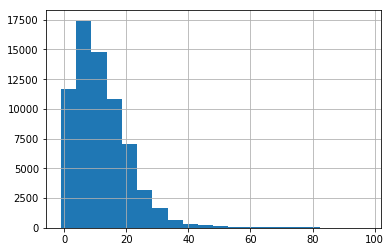

In [11]:
summary(df.p_floor_int)
df.p_floor_int.hist(bins=20);

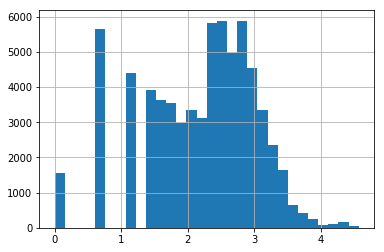

In [12]:
df['p_floor_log'] = np.log( df.p_floor_int )
df['p_floor_log'].hist(bins=30);

1th -> 20.0
5th -> 31.24000000000001
95th -> 128.0
99th -> 216.0
100th -> 1971.1


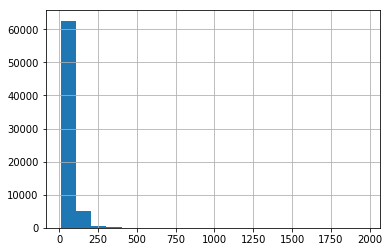

In [13]:
summary(df.p_total_area )
df.p_total_area .hist(bins=20);

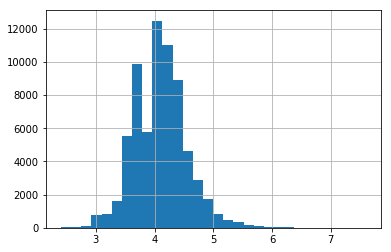

In [14]:
df['p_total_area_log'] = np.log( df.p_total_area )
df['p_total_area_log'].hist(bins=30);

1th -> 5.0
5th -> 8.0
95th -> 1725.0
99th -> 2331.0
100th -> 6377.0


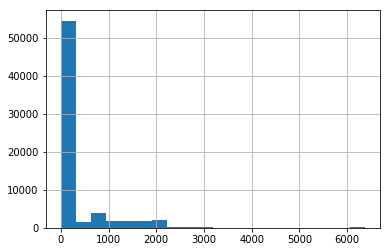

In [15]:
summary(df.p_number_of_floors )
df.p_number_of_floors.hist(bins=20);

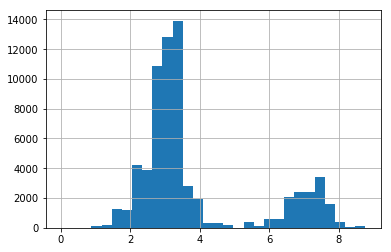

In [16]:
df['p_number_of_floors_log'] = np.log( df.p_number_of_floors )
df['p_number_of_floors_log'].hist(bins=30);

## Model

In [17]:
def custom_rmsle(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred[ y_pred < 0 ] = 0

    return rmsle(y_test, y_pred)

def get_feats(data, exclude_feats=[]):
    selected_feats = list(data.select_dtypes(include=[np.number, np.bool]).columns)
    black_list = ['price', 'is_test', 'id'] + exclude_feats
    return [feat for feat in selected_feats if feat not in black_list]

In [18]:
exclude_feats = ['p_price', 
                 'p_price_m2',
                 'p_bathroom_type', 
                 'p_the_view_from_the_window',
                 'p_living_room',
                 'p_garbage_chute',
                 'p_elevator',
                 'p_floor_int',
                 'p_total_area',
                 'p_repair',
                 'p_the_largest_number_of_floors',
                 'p_year_built',
                 'p_kitchen_area'
                ]

feats = get_feats(df, exclude_feats)
sorted(feats)

['last_floor',
 'p_building_type',
 'p_ceiling_height',
 'p_construction_phase',
 'p_floor_log',
 'p_housing_class',
 'p_mortgage_possible',
 'p_number_of_apartments',
 'p_number_of_buildings',
 'p_number_of_dwellings',
 'p_number_of_entrances',
 'p_number_of_floors',
 'p_number_of_floors_log',
 'p_number_of_rooms',
 'p_object_type',
 'p_phone',
 'p_room_type',
 'p_total_area_log']

In [19]:
train, test = df[ False == df.price.isnull() ], df[ df.price.isnull() ]

X_train = train[ feats ].values
y_train = train['price'].values
y_log = np.log(y_train)

X_test = test[ feats ].values

In [20]:
model_params = {
        'max_depth': 20,
        'learning_rate': 0.2,
        'n_estimators': 100,
        'n_jobs': 5
    }

model = xgb.XGBRegressor(**model_params,)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=custom_rmsle)
print(np.mean(scores), np.std(scores))

explain_weights_xgboost(model, feature_names=feats, top=50)

[21:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.17939637862093702 0.009444418531752565


Weight,Feature
0.2835,p_total_area_log
0.1714,p_housing_class
0.1383,p_number_of_floors_log
0.0860,p_number_of_apartments
0.0699,p_number_of_floors
0.0516,p_number_of_entrances
0.0288,p_mortgage_possible
0.0265,p_number_of_buildings
0.0256,p_number_of_dwellings
0.0219,p_construction_phase


[21:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

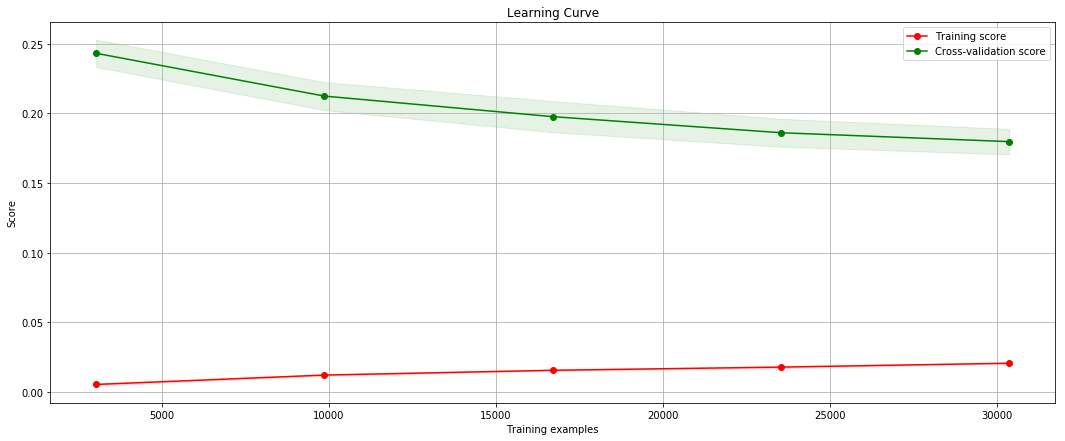

In [21]:
plot_learning_curve(model, X_train, y_train, cv=3, figsize=(18, 7), scoring=custom_rmsle);

In [22]:
model.fit(X_train, y_log)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

test['price'] = y_pred
test[ ['id', 'price'] ].to_csv('./output/model_xgb.csv', index=False)

[21:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
